In [6]:
import sys
sys.path.append('../src')
import os
import rpy2
import rpy2.robjects as robjects
import rpy2.rinterface as rinterface
from rpy2.robjects.packages import importr, data
from rpy2.robjects.methods import getmethod
from rpy2.robjects import numpy2ri
from rpy2.robjects import default_converter
from rpy2.robjects import pandas2ri
import numpy as np
import rpy2_Matrix.conversion as matrix_conversion
import pandas as pd
from mcmc.utils.graph_utils import generate_DAG, generate_key_from_adj_matrix
from mcmc.evaluation.metrics import kl_divergence, jensen_shannon_divergence, mean_squared_error, mean_absolute_error
from matplotlib import pyplot as plt


bidag = importr('BiDAG')
np_cv_rules = default_converter + numpy2ri.converter + pandas2ri.converter
np.load('results/ablation_nodes=3_edgep=0.25_r=0.npz', allow_pickle=True)['true_posterior']

array({'000 000 000': 2.796114969988136e-50, '010 000 000': 1.6619680129227882e-46, '001 000 000': 1.8873500916027333e-40, '000 100 000': 1.661968012923166e-46, '000 001 000': 4.7387946561284756e-11, '000 000 100': 1.887350091602948e-40, '000 000 010': 4.7387946561284756e-11, '011 000 000': 1.121812055333441e-36, '010 001 000': 2.8166671338014695e-07, '010 000 100': 1.121812055333441e-36, '010 000 010': 9.976958436935557e-13, '001 100 000': 1.1218120553335686e-36, '001 001 000': 1.1329949357298283e-06, '001 000 010': 0.31986397642188463, '000 101 000': 2.81666713380179e-07, '000 100 100': 3.973587122099249e-42, '000 100 010': 2.81666713380179e-07, '000 001 100': 0.31986397642188463, '000 000 110': 0.31986397642188463, '011 001 000': 0.006734348773914952, '011 000 010': 0.006734348773916484, '010 000 110': 0.006734348773916484, '001 101 000': 0.006734348773916484, '000 101 100': 0.006734348773915718, '000 100 110': 0.006734348773916484},
      dtype=object)

In [7]:
KLD = {}
JSD = {}
MSE = {}
MAE = {}

for root, folders, files in os.walk('results'):
    for file in files:
        if 'ablation' in file:
            data_compressed = np.load(os.path.join(root, file), allow_pickle=True) #np.load('ablation_nodes=3_edgep=0.25_r=0.npz')
            _, num_nodes, edge_p, n_repeat = file[:-4].split('_')
            num_nodes = int(num_nodes.split('=')[1])
            edge_p = float(edge_p.split('=')[1])
            n_repeat = int(n_repeat.split('=')[1])

            if num_nodes not in KLD:
                KLD[num_nodes] = {}
                JSD[num_nodes] = {}
                MSE[num_nodes] = {}
                MAE[num_nodes] = {}

            if edge_p not in KLD[num_nodes]:
                KLD[num_nodes][edge_p] = {'bidag': [], 'mcmc': []}
                JSD[num_nodes][edge_p] = {'bidag': [], 'mcmc': []}
                MSE[num_nodes][edge_p] = {'bidag': [], 'mcmc': []}
                MAE[num_nodes][edge_p] = {'bidag': [], 'mcmc': []}
            try:
                data = data_compressed['data']
                labels = data_compressed['node_labels']
                dag = data_compressed['dag']
                true_distribution = data_compressed['true_posterior'].item()
                approx_distribution = data_compressed['posterior'].item()
                data_pd = pd.DataFrame(data, columns=labels)
            except:
                print('skipping', file)
                continue

            with np_cv_rules.context():
                score = bidag.scoreparameters(scoretype="bge", data=data_pd)
                pmcmc = bidag.partitionMCMC(scorepar=score, iterations=30000)

                graphs = [robjects.r['as.matrix'](g[1]) for g in list(pmcmc['traceadd']['incidence'].items())]

                keys, counts = np.unique([generate_key_from_adj_matrix(g) for g in graphs], return_counts=True)

                dst = {key:count/sum(counts) for key, count in zip(keys, counts)}
                approx_distribution_r = {key: (dst[key] if key in dst else 0) for key in true_distribution.keys()}

                KLD[num_nodes][edge_p]['bidag'].append(kl_divergence(approx_distribution_r, true_distribution))
                JSD[num_nodes][edge_p]['bidag'].append(jensen_shannon_divergence(approx_distribution_r, true_distribution))
                MSE[num_nodes][edge_p]['bidag'].append(mean_squared_error(approx_distribution_r, true_distribution))
                MAE[num_nodes][edge_p]['bidag'].append(mean_absolute_error(approx_distribution_r, true_distribution))

                KLD[num_nodes][edge_p]['mcmc'].append(kl_divergence(approx_distribution, true_distribution))
                JSD[num_nodes][edge_p]['mcmc'].append(jensen_shannon_divergence(approx_distribution, true_distribution))
                MSE[num_nodes][edge_p]['mcmc'].append(mean_squared_error(approx_distribution, true_distribution))
                MAE[num_nodes][edge_p]['mcmc'].append(mean_absolute_error(approx_distribution, true_distribution))

                print(data_compressed['kld'], KLD[num_nodes][edge_p]['bidag'][-1])
                print(data_compressed['jsd'], JSD[num_nodes][edge_p]['bidag'][-1])
                print(data_compressed['mae'], MAE[num_nodes][edge_p]['bidag'][-1])
                print(data_compressed['mse'], MSE[num_nodes][edge_p]['bidag'][-1])
                print('-----')

                np.savez(f'results_r/ablation_nodes={num_nodes}_edgep={edge_p}_r={n_repeat}.npz', dag=dag, init_dag=None, data=data, node_labels=labels, posterior=approx_distribution, true_posterior=true_distribution, kld=KLD[num_nodes][edge_p]['bidag'][-1], jsd=JSD[num_nodes][edge_p]['bidag'][-1], mse=MSE[num_nodes][edge_p]['bidag'][-1], mae=MAE[num_nodes][edge_p]['bidag'][-1])


0.03538286745547724 0.0444764290150487
0.00846171649119404 0.011205283752117375
0.00968406908703351 0.009822765290145762
0.0007193477150518614 0.0006392148523730228
-----
0.004695596256101284 0.0066364505814574745
0.0012432084330926728 0.0017672424172031245
0.002135636849513581 0.0017219669997372584
3.566146146334156e-05 1.2371154145098177e-05
-----
0.03475908983598941 0.0537573065697551
0.00868855173629318 0.013269850055381739
0.009564323077728244 0.010614696725055148
0.0006780783072671999 0.0007703877518595512
-----
0.003302902346788016 0.010639185808860353
0.000758428248974879 0.002832337827372463
0.0009949541565596265 0.0021874789186271614
3.910391318745584e-06 1.713630487210967e-05
-----


In [10]:
np.savez(f'summary.npz', kld=KLD, jsd=JSD, mse=MSE, mae=MAE)

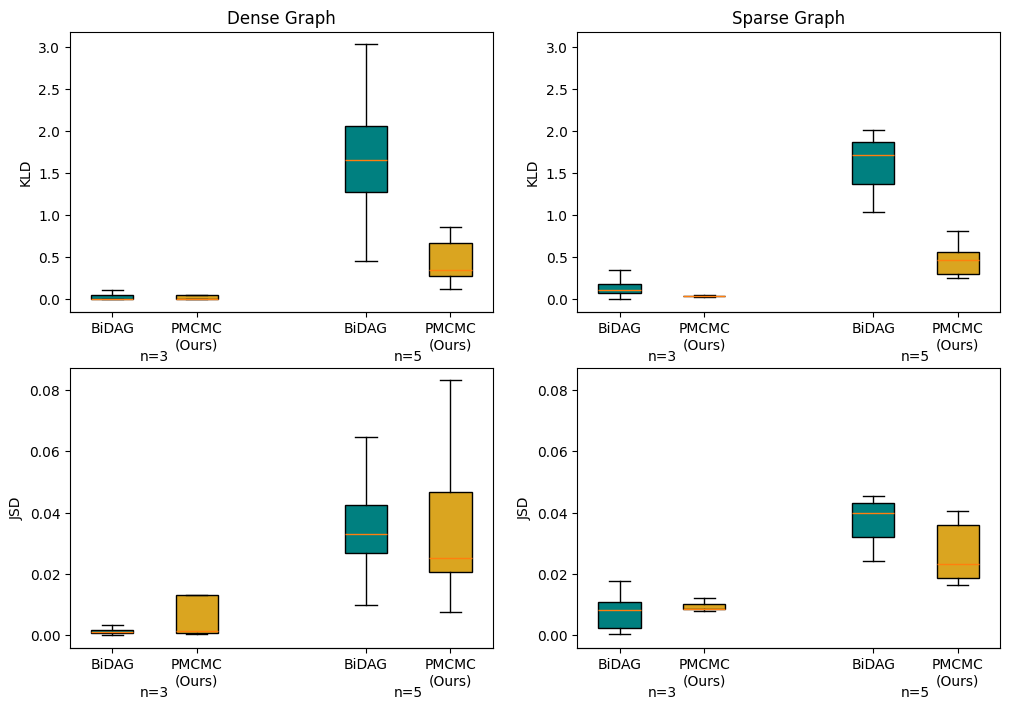

In [96]:
import seaborn as sns
from matplotlib import pyplot as plt

# print(KLD[3][0.25]['bidag'])
plt.rcParams['figure.figsize'] = 12,8
fig, ax = plt.subplots(2,2)

metrics = {"KLD":KLD, "JSD":JSD}
for idx_m, metric_name in enumerate(metrics.keys()):

    for idx_ep, edge_p in enumerate([0.5, 0.25]):

        boxes = ax[idx_m, idx_ep].boxplot([metrics[metric_name][3][edge_p]['bidag'], metrics[metric_name][5][edge_p]['bidag'], metrics[metric_name][3][edge_p]['mcmc'], metrics[metric_name][5][edge_p]['mcmc']], positions=[1,4,2,5], showfliers=False, patch_artist=True)
        ax[idx_m, idx_ep].set_xticks([1,2,4,5],['BiDAG', 'PMCMC\n(Ours)', 'BiDAG', 'PMCMC\n(Ours)'])

        if idx_m ==0:
            ax[idx_m, idx_ep].set_title('Dense Graph' if edge_p==0.5 else 'Sparse Graph')

        if edge_p > 0:
            ax[idx_m, idx_ep].sharey(ax[idx_m, 0])
        ax[idx_m, idx_ep].set_ylabel(metric_name)

        sec = ax[idx_m, idx_ep].secondary_xaxis(location=0)
        sec.tick_params('x', length=0)
        sec.set_xticks([1.5,4.5], labels=['\n\nn=3', '\n\nn=5'])

        # fill with colors
        colors = ['teal', 'teal', 'goldenrod', 'goldenrod']
        for patch, color in zip(boxes['boxes'], colors):
            patch.set_facecolor(color)

plt.savefig('BiDAG_comparison.png')